In [31]:
import seaborn as sns
sns.set()
import altair as alt

In [32]:
import numpy as np
import pandas as pd
from numpy import random as rd
import tensorflow as tf
from tensorflow import keras

from sklearn.compose import ColumnTransformer

# SQLite and Data Preprocessing 


### SQL to Dataframe  

In [33]:

import sqlalchemy
from sqlalchemy import create_engine

from sqlalchemy import inspect


In [25]:
engine = create_engine("sqlite:///microstructures.sqlite")

In [34]:
MicrostrucureData = sqlalchemy.MetaData(bind = engine)

In [35]:
conn = engine.connect()

In [23]:
inspector = inspect(engine)

In [24]:

for table_name in inspector.get_table_names():
   for column in inspector.get_columns(table_name):
       print("Table: %s" % table_name , " Column: %s" % column['name'])
        

In [36]:
#### JOINS the micrograph table to the sample data table


micrographs = """

SELECT *
FROM micrograph JOIN sample ON sample_id = sample_key


"""

In [37]:
###  This is the main dataframe
micrographs_df =pd.read_sql_query(micrographs, conn)

In [42]:

micrographs_df.head()

,micrograph_id,path,micron_bar,micron_bar_units,micron_bar_px,magnification,detector,sample_key,contributor_key,primary_microconstituent,sample_id,label,anneal_time,anneal_time_unit,anneal_temperature,anneal_temp_unit,cool_method
0,1,micrograph1.tif,5.0,um,129,4910x,SE,42,2,pearlite,42,ET Gyro,NaN,None,NaN,None,None
1,2,micrograph2.tif,10.0,um,103,1964X,SE,18,2,spheroidite,18,AC1 800C 85H WQ,85.0,H,800.0,C,WQ
2,4,micrograph4.tif,10.0,um,129,None,SE,35,2,pearlite+spheroidite,35,AC1 970C 90M FC,90.0,M,970.0,C,FC
3,5,micrograph5.tif,5.0,um,129,4910X,SE,10,2,pearlite,10,AC1 750C 5M WQ,5.0,M,750.0,C,WQ
4,6,micrograph6.tif,20.0,um,124,1178X,SE,29,2,spheroidite,29,AC1 970C 90M AR,90.0,M,970.0,C,AR


Above we see that the main features are:\
&emsp; magnification\
&emsp; primary_microconstituent\
&emsp; anneal_time (along with anneal_time_unit)\
&emsp; anneal_temp\
&emsp; cool_method
    

### Custom Transformers for Data Preprocessing

The anneal time is in minutes and hours, and we will convert evething to minutes.\
The anneal temperature is Celsius which is bad for scaling so we will convert to Kelvin

In [38]:
from sklearn.base import BaseEstimator,TransformerMixin

In [53]:
class ToKelvin(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y= None):
        return self
        
    def transform(self, X, y = None):
        return X + 273.15
    

In [54]:
class ToMinute(BaseEstimator, TransformerMixin):
    
    def __init__(self, dataseries):
        self.dataseries = dataseries
        self.multi = self.dataseries.apply(self._M_to_K)
        
    def _M_to_K(self, char):
        if char == 'H':
            return 60
        if char == 'M':
            return 1
        else: 
            return 0
        
    def fit(self,X,y = None):
        return self
    
    
    def transform(self, X, y = None):
        
        return X*self.multi
    

## This is our main preprocssing dataframe

In [75]:
###  This is our main data frame before preprocessing

preprocess_micrographs_df = micrographs_df[['path',
                                 'sample_id',
                                 'anneal_time',
                                 'anneal_time_unit',
                                 'anneal_temperature'
                                ]]

In [76]:
#convert to Kelvin

preprocess_micrographs_df['anneal_temperature_Kelvin'] = preprocess_micrographs_df['anneal_temperature'] + 273.15

C:\Users\Owner\AppData\Local\Temp\ipykernel_3600\2128548814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_micrographs_df['anneal_temperature_Kelvin'] = preprocess_micrographs_df['anneal_temperature'] + 273.15


In [84]:
preprocess_micrographs_df.head()

,path,sample_id,anneal_time,anneal_time_unit,anneal_temperature,anneal_temperature_Kelvin,anneal_time_minutes
0,micrograph1.tif,42,NaN,None,NaN,NaN,NaN
1,micrograph2.tif,18,85.0,H,800.0,1073.15,5100.0
2,micrograph4.tif,35,90.0,M,970.0,1243.15,90.0
3,micrograph5.tif,10,5.0,M,750.0,1023.15,5.0
4,micrograph6.tif,29,90.0,M,970.0,1243.15,90.0


In [82]:
to_minute = ToMinute(preprocess_micrographs_df['anneal_time_unit'])
preprocess_micrographs_df['anneal_time_minutes'] = to_minute.transform(preprocess_micrographs_df['anneal_time'])

C:\Users\Owner\AppData\Local\Temp\ipykernel_3600\1233792887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_micrographs_df['anneal_time_minutes'] = to_minute.transform(preprocess_micrographs_df['anneal_time'])


## This is our main data frame

In [88]:
# this is our main micrograph data frame. 
# It contains the file paths, sample_ids (for balancing), temerature in Kelvin, and time in minutes

main_micrographs_df = preprocess_micrographs_df[['path',
                                                 'sample_id', 
                                                 'anneal_temperature_Kelvin', 
                                                 'anneal_time_minutes']]

In [89]:
main_micrographs_df.head()

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes
0,micrograph1.tif,42,NaN,NaN
1,micrograph2.tif,18,1073.15,5100.0
2,micrograph4.tif,35,1243.15,90.0
3,micrograph5.tif,10,1023.15,5.0
4,micrograph6.tif,29,1243.15,90.0


## Train-Test Split 

We are splitting on sample_id with a stratified split to deal with imbalances.



In [91]:
from sklearn.model_selection import train_test_split

In [96]:
train_main, test_main = train_test_split(main_micrographs_df, test_size = 0.1, stratify = main_micrographs_df['sample_id'])

Replace NaN with 'Not Annealed' Label for classification task.

In [93]:
train_class = train_main.copy().fillna('Not Annealed')
test_class = test_main.copy().fillna('Not Annealed')

Drop Nan rows for regression tastk

In [114]:
train_regression_preweight = train_main.copy().dropna()
test_regressioin_preweight = test_main.copy().dropna()

## Class Weights and StandardScaler

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = train_class['sample_id'].unique(),
                                     y = train_class['sample_id'])

CLASS_WEIGHTS = dict(zip(train_class['sample_id'].unique(),class_weights))

For Regression we use sample weights on 'sample_id' and the StandardsScaler on temperature and time

In [115]:
sample_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = train_regression_preweight['sample_id'].unique(),
                                     y = train_regression_preweight['sample_id'])

SAMPLE_WEIGHTS = pd.DataFrame(zip(train_regression_preweight['sample_id'].unique(),sample_weights), columns = ['sample_id','sample_weights'])

In [116]:
train_regression = pd.merge(train_regression_preweight, SAMPLE_WEIGHTS, on = 'sample_id')

In [117]:
train_regression

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes,sample_weights
0,micrograph1694.tif,38,1243.15,5.0,1.451351
1,micrograph1003.tif,38,1243.15,5.0,1.451351
2,micrograph1013.tif,38,1243.15,5.0,1.451351
3,micrograph1586.tif,38,1243.15,5.0,1.451351
4,micrograph286.tif,38,1243.15,5.0,1.451351
...,...,...,...,...,...
532,micrograph1063.tif,22,1173.15,5.0,7.256757
533,micrograph218.tif,10,1023.15,5.0,3.628378
534,micrograph5.tif,10,1023.15,5.0,3.628378
535,micrograph301.tif,10,1023.15,5.0,3.628378


In [494]:
scaler = StandardScaler()

m_a_trunc[['anneal_time_minutes', 'anneal_temperature']] = scaler.fit_transform(m_a_trunc[['anneal_time_minutes', 'anneal_temperature']] )


C:\Users\Owner\AppData\Local\Temp\ipykernel_22316\232795710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_a_trunc[['anneal_time_minutes', 'anneal_temperature']] = scaler.fit_transform(m_a_trunc[['anneal_time_minutes', 'anneal_temperature']] )


In [495]:
m_a_trunc

,path,anneal_time_minutes,anneal_temperature
1,micrograph2.tif,3.917963,-1.439328
3,micrograph5.tif,-0.588127,-2.039617
4,micrograph6.tif,-0.512952,0.601656
5,micrograph7.tif,-0.512952,0.601656
7,micrograph9.tif,-0.512952,0.601656
...,...,...,...
792,micrograph1716.tif,3.917963,-1.439328
795,micrograph1720.tif,0.681007,-1.439328
797,micrograph1722.tif,0.681007,0.601656
799,micrograph1726.tif,-0.588127,0.601656


# Transfer Learning:  InceptionV3 Regeression model with stratified train test data


In [ ]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from sklearn.metrics import classification_report

In [1457]:
R_X = 'path'
R_Y = [ 'anneal_time_minutes','anneal_temperature']

In [ ]:
# do the sample weights by sample_id.  we make a column in the dataframe that containst the sampleweights

In [1470]:
train_regression = data_generator.flow_from_dataframe(dataframe = m_a_trunc,
                                                directory = df_dir,
                                                x_col = R_X,
                                                y_col = R_Y,
                                                class_mode= 'raw',
                                                color_mode = 'rgb',
                                                sample_weights = t_class_weights,
                                                target_size = TARGET_SIZE,
                                                batch_size = 32)

validation_regression = validation_generator.flow_from_dataframe(dataframe = m_a_trunc,
                                                directory = df_dir,
                                                x_col = R_X,
                                                y_col = R_Y,
                                                class_mode = 'raw',
                                                color_mode = 'rgb',
                                                sample_weights = t_class_weights,
                                                target_size = TARGET_SIZE,
                                                batch_size = 32)

Found 495 validated image filenames.
Found 32 validated image filenames.


In [871]:
inception = keras.applications.inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape = (256,256,3))

In [872]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
    
def trans_reg_model_builder(training_data):
    model = Sequential()
    
    model.add(tf.keras.Input(shape=(522,645,3)))
    model.add(layers.Rescaling(scale = 1./255))
    model.add(layers.Cropping2D(
              cropping=((0, 40), (0, 0))
                ))
    
    model.add(layers.RandomFlip())
    model.add(layers.RandomRotation(factor = 0.4, 
                                    fill_mode = 'reflect'))
    
    model.add(layers.RandomZoom(.4,.2)
    model.add(layers.RandomContrast(.2))          
    model.add(layers.RandomCrop(256,256))
    
    model.add(inception)
    model.add(layers.Flatten())
    
    
    model.add(layers.Dense(500, activation = 'relu'))
    
    model.add(layers.Dropout(.3))
    
    model.add(layers.Dense(2))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = .001),
                loss ='mse',
                metrics=[tf.keras.metrics.mean_squared_error]
                 )
    
    model.summary()
    return model

In [1565]:
trans_reg_model = trans_reg_model_builder(train_regression)


Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_72 (CenterCrop  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_182 (Flatten)       (None, 73728)             0         
                                                                 
 dense_454 (Dense)           (None, 500)               36864500  
                                                                 
 dropout_412 (Dropout)       (None, 500)               0         
                                                                 
 dense_455 (Dense)           (None, 2)                 1002      
                                                    

In [1568]:
mse_hist = mse_hist[1:]
mse_valid_hist = mse_valid_hist[1:]

In [ ]:
#mse_hist = []
#mse_valid_hist = []


reg_data_generator = ImageDataGenerator()

reg_validation_generator = ImageDataGenerator()

DIRECTORY = "micrographs"
CLASS_MODE = 'categorical'
COLOR_MODE = 'rbg'
TARGET_SIZE = (645,522)
BATCH_SIZE = 32

    df_dir = 'micrographs'
    DATAFRAME =  new_df#ohe_main_micrographs
    XCOL =  'path'
    YCOL = ['anneal_temperature']

    df_train_tr = reg_data_generator.flow_from_dataframe(dataframe = m_a_trunc,
                                                    directory = df_dir,
                                                    x_col = R_X,
                                                    y_col = R_Y,
                                                    class_mode= 'raw',
                                                    color_mode = 'rgb',
                                                    subset = 'training',
                                                    sample_weights = t_class_weights,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = 32)

    df_valid_tr = reg_validation_generator.flow_from_dataframe(dataframe = m_a_trunc,
                                                    directory = df_dir,
                                                    x_col = R_X,
                                                    y_col = R_Y,
                                                    class_mode = 'raw',
                                                    color_mode = 'rgb',
                                                    sample_weights = t_class_weights,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = 32)




    trans_reg_model_fit = trans_reg_model.fit(df_train_tr,
                         steps_per_epoch = df_train_tr.samples/BATCH_SIZE,
                         epochs = 5,
                         validation_data = df_valid_tr,
                         validation_steps = df_valid_tr.samples/BATCH_SIZE,
                         callbacks = None #[early_stop]
                         )
    
    mse_hist += trans_reg_model_fit.history['mean_squared_error']
    mse_valid_hist +=trans_reg_model_fit.history['val_mean_squared_error']
    

Loop:  1
Found 431 validated image filenames.
Found 96 validated image filenames.
Epoch 1/5
13/13 [==============================] - 44s 3s/step - loss: 0.2715 - mean_squared_error: 0.2715 - val_loss: 0.3230 - val_mean_squared_error: 0.3230
Epoch 2/5
13/13 [==============================] - 41s 3s/step - loss: 0.2806 - mean_squared_error: 0.2806 - val_loss: 0.3385 - val_mean_squared_error: 0.3385
Epoch 3/5
13/13 [==============================] - 43s 3s/step - loss: 0.2320 - mean_squared_error: 0.2320 - val_loss: 0.3644 - val_mean_squared_error: 0.3644
Epoch 4/5
13/13 [==============================] - 43s 3s/step - loss: 0.2236 - mean_squared_error: 0.2236 - val_loss: 0.3422 - val_mean_squared_error: 0.3422
Epoch 5/5
13/13 [==============================] - 42s 3s/step - loss: 0.2938 - mean_squared_error: 0.2938 - val_loss: 0.3710 - val_mean_squared_error: 0.3710
Loop:  2
Found 399 validated image filenames.
Found 128 validated image filenames.
Epoch 1/5
12/12 [=======================

<function matplotlib.pyplot.show(close=None, block=None)>

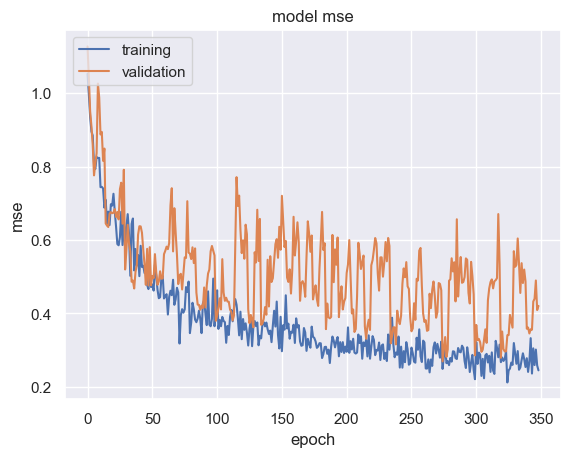

In [1582]:
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(mse_hist)
ax1.plot(mse_valid_hist)
ax1.set_title('model mse')
ax1.set_xlabel('epoch')
ax1.set_ylabel('mse')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
#classification report 

test_steps_per_epoch = np.math.ceil(df_valid_it.samples / df_valid_it.batch_size)
predictions = model_df.predict(df_valid_it, steps=test_steps_per_epoch)
test_steps_per_epoch = np.math.ceil(df_valid_it.samples / df_valid_it.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = df_valid_it.classes
class_labels = list(df_valid_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   



# Classification model with data augmentation in layers stratified train-test validation

I'll be switching the data augmentation to the layers for the keras model rather than using the DataImageGeneartor


In [ ]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

In [ ]:
col_select = ['micrograph_id', 'anneal_time', 'anneal_time_unit', 'anneal_temperature']

In [ ]:
to_min = ToMinutes(time_temp['anneal_time_unit'])
anneal_time_minute = to_min.transform(time_temp['anneal_time'])

In [ ]:
time_temp = m_s_pd[col_select]

In [ ]:
time_temp.insert(2, 'anneal_time_minutes', anneal_time_minute,True)

In [ ]:
time_temperature = time_temp[['micrograph_id','anneal_time_minutes','anneal_temperature']]


In [ ]:
tt_df['tt_start'] = tt_df['anneal_time_minutes'].astype(str) + "_" + tt_df['anneal_temperature'].astype(str)

In [ ]:
train, test = train_test_split(tt_df, test_size = 0.3, stratify = tt_df['tt_start'])

class weighting using sklearn

In [ ]:
cw_dict = dict(zip(train['anneal_time_minutes'].unique(),class_weights))

New Model Constructions


preprocessing layers \
2D cropping layer \
rescaling (perhaps keep this in dataimagegenerator )


data augmentation\
random crop\
random flip\
random trnslation\
random rotation\
random zoon\
random contrast\

In [2]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
tt_df = time_temperature.fillna('Not Annealed')

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = train['anneal_time_minutes'].unique(),
                                     y = train['anneal_time_minutes'])

CLASS_WEIGHTS = dict(zip(train['anneal_time_minutes'].unique(),class_weights))

In [ ]:


data_generator = ImageDataGenerator(rescale = 1./255)

validation_generator = ImageDataGenerator(rescale = 1./255)


    
BATCH_SIZE = 32
DIRECTORY = "micrographs"
DATAFRAME =  new_df#ohe_main_micrographs
XCOL =  'path'
YCOL = 'time_temperature'
COLOR_MODE = 'rbg'
TARGET_SIZE = (645,522)


train_tt = data_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                              directory = DIRECTORY,
                                              x_col = XCOL,
                                              y_col = YCOL,
                                              class_mode = 'categorical',
                                              classes = tt_classes,
                                              shuffle = True,
                                              target_size = TARGET_SIZE,
                                              sample_weights = CLASS_WEIGHTS,
                                              batch_size = BATCH_SIZE)

validation_tt = validation_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                                        directory = DIRECTORY,
                                                        x_col = XCOL,
                                                        y_col = YCOL,
                                                        class_mode = 'categorical',
                                                        classes = tt_classes,
                                                        target_size = TARGET_SIZE,
                                                        batch_size = BATCH_SIZE)





In [ ]:
def cat_model_builder(training_data):
    model = Sequential()
    
    model.add(tf.keras.Input(shape=(522,645,3)))

    model.add(layers.Rescaling(scale = 1./255))
    model.add(layers.Cropping2D(cropping=((0, 40), (0, 0))))
    
    model.add(layers.RandomFlip())
    model.add(layers.RandomRotation(factor = 0.4, 
                                    fill_mode = 'reflect'))
    model.add(layers.RandomZoom(.4,.2)
    model.add(layers.RandomContrast(.2))          
    model.add(layers.RandomCrop(256,256))
    
    
    model.add(inception)
    
    model.add(layers.Flatten())

    model.add(layers.Dense(500, activation = 'sigmoid'))
    
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(21, activation = 'softmax'))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = .001),
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = tf.keras.metrics.CategoricalAccuracy() #,tf.keras.metrics.AUC()]
                 )
    
    model.summary()
    return model
    
    

In [ ]:
tt_categorical_ model = cat_model_builder(train_tt)

In [ ]:
cat_acc_history = []
val_cat_history = []

In [ ]:


 
model_fit_df = model_df.fit(train_tt,
                           steps_per_epoch = df_train_it.samples/BATCH_SIZE,
                           epochs = 5,
                           validation_data = validation_tt,
                           validation_steps = df_valid_it.samples/BATCH_SIZE
                            )

cat_acc_history += model_fit_df.history['categorical_accuracy']
val_cat_history += model_fit_df.history['val_categorical_accuracy']
    
    
       
    
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(cat_acc_history)
ax1.plot(val_cat_history)
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# classification report

test_steps_per_epoch = np.math.ceil(df_valid_it.samples / df_valid_it.batch_size)
predictions = model_df.predict(df_valid_it, steps=test_steps_per_epoch)
test_steps_per_epoch = np.math.ceil(df_valid_it.samples / df_valid_it.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = df_valid_it.classes
class_labels = list(df_valid_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

